In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# native tools
import sys
from copy import copy
from collections import Counter
from joblib import dump, load

# for data analysis 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature selection
from sklearn.feature_selection import VarianceThreshold

# feature engineering 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# for outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# for imbalanced classes
from imblearn.over_sampling import SMOTENC

# linear models
from sklearn.linear_model import LogisticRegression

# non-linear models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# modeling building tools
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, precision_recall_curve, PrecisionRecallDisplay)


# custom functions, classes, etc ... 
sys.path.append("../Scripts")
from deep_learning import BuildNeuralNetArchitecture
from prep_data import PrepDataForModeling
from train_models import TrainModels
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


----

# Prep data for modeling

In [2]:
data_path = "../Data/fraud_detection_bank_dataset.csv"
prep_data = PrepDataForModeling(data_path, y_col='targets')

X_train, y_train, X_test, y_test = prep_data.gen_model_ready_data(return_data=True)

INFO:root:Loading data from ../Data/fraud_detection_bank_dataset.csv
INFO:root:Number of features dropped 51. Number of features remaining 62
INFO:root:Using statistical_outlier_removal to remove outliers
INFO:root:Splitting data into training and test sets
INFO:root:Using SMOTENC to balance out labels in train set only.
INFO:root:Original imbalanced label count for training data Counter({0: 3498, 1: 1328})
INFO:root:New balanced label count for training data Counter({0: 3498, 1: 3498})


---
# Build Models 

In [3]:
model_list = ["LogisticRegression", 
              "RandomForestClassifier",
              "LGBMClassifier"
             ]

train_models = TrainModels(X_train, 
                           y_train, 
                           X_test, 
                           y_test)

# Creates a data transform pipeline that handels categorical and numerical features differently
train_models.create_transform_portion_of_pipeline(prep_data.df)

#Performs a grid search for each pipeline object
train_models.grid_search_models(model_list)

best_pipeline = train_models.return_best_pipeline()

INFO:root:Training LogisticRegression ...


Fitting 3 folds for each of 2 candidates, totalling 6 fits


INFO:root:Logging LogisticRegression as best performing model.
INFO:root:Best LogisticRegression has test score 0.8935
INFO:root:Training RandomForestClassifier ...


Fitting 3 folds for each of 6 candidates, totalling 18 fits


INFO:root:Logging RandomForestClassifier as best performing model.
INFO:root:Best RandomForestClassifier has test score 0.9191
INFO:root:Training LGBMClassifier ...


Fitting 3 folds for each of 16 candidates, totalling 48 fits


INFO:root:Logging LGBMClassifier as best performing model.
INFO:root:Best LGBMClassifier has test score 0.9272


In [4]:
# best_pipeline is a grid search object with a pipeline within it
# we need to index for the model itself 
best_model = best_pipeline.best_estimator_["model"]
best_model

LGBMClassifier(reg_alpha=0.01)

----
### Post Modeling Analysis

In [5]:
train_models.create_metric_df()

,Accuracy,Precision,Recall,F1_Score
LogisticRegression,0.8935,0.8463,0.7575,0.7994
RandomForestClassifier,0.9191,0.8984,0.8018,0.8474
LGBMClassifier,0.9272,0.8857,0.8497,0.8673


In [6]:
train_models.create_metric_df(adj_threshold=True)

,Accuracy,Precision,Recall,F1_Score,New_Threshold
LogisticRegression,0.8885,0.7735,0.8510,0.8104,0.3476
RandomForestClassifier,0.9233,0.8565,0.8722,0.8643,0.3910
LGBMClassifier,0.9269,0.8570,0.8871,0.8718,0.3792


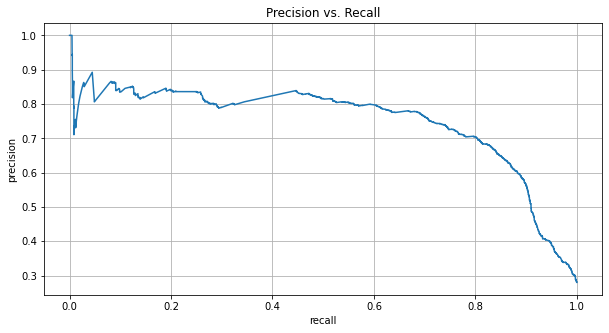

In [17]:
# TODO: create plot that displays all model curves 
df_gbt_pre_rec = train_models.create_precision_recall_df(best_model, plot=False)

x = "recall"
y = "precision"
title = "Precision vs. Recall"
df_gbt_pre_rec.plot(x=x, 
                    y=y,
                    grid=True, 
                    figsize=(10,5), 
                    title=title, 
                    ylabel=y, 
                    legend=False);

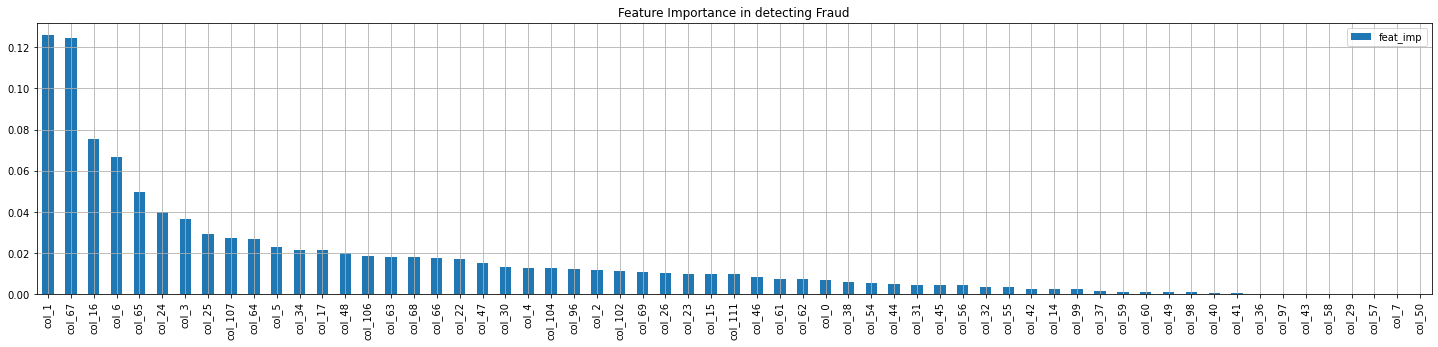

In [18]:
df_feat_importance = train_models.create_feature_importance_df(best_model, prep_data.x_cols)

title = "Feature Importance in detecting Fraud"
df_feat_importance.sort_values("feat_imp", ascending=False).plot(kind="bar", grid=True, legend=True,
                                                          figsize=(25, 5), use_index=True, title=title);